In [25]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    brier_score_loss,
    RocCurveDisplay)
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
import json
from pathlib import Path
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from os import listdir
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
np.random.seed(42)
RANDOM_STATE= 42
data_folder= "data/"
image_folder = "artifacts/figures/"
artifacts_folder="artifacts/"
datasets_files = [
'data/S07-hw-dataset-01.csv',
'data/S07-hw-dataset-02.csv',
'data/S07-hw-dataset-03.csv',
 'data/S07-hw-dataset-04.csv']
def plot_k_metrics(metrics, title_suffix=""):
    k = metrics["k"]
    inertia = metrics["inertia"]
    sil = metrics["silhouette"]

    plt.figure(figsize=(7, 4))
    plt.plot(k, inertia, marker="o")
    plt.title(f"Inertia vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("inertia_ (ниже лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(k, sil, marker="o")
    plt.title(f"Silhouette vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("silhouette (выше лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()
def plot_clusters(X,labels,title='',fig=None,ax=None,save_file=None):
    X= PCA(2,random_state=RANDOM_STATE).fit_transform(X)
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    labels = np.asarray(labels)
    unique = sorted(set(labels))
    for lab in unique:
        mask = labels == lab
        if lab == -1:
            ax.scatter(X[mask, 0], X[mask, 1], s=20, marker="x", label="noise (-1)")
        else:
            ax.scatter(X[mask, 0], X[mask, 1], s=20, label=f"cluster {lab}")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")
    if save_file !=None:
        fig.savefig(save_file)
    fig.show()
    #print(X)
def safe_internal_metrics(X, labels):
    
    labels = np.asarray(labels)
    mask = labels != -1
    X2 = X[mask]
    y2 = labels[mask]

    result = {}

    
    if len(set(y2)) < 2:
        result["silhouette"] = None
        result["calinski_harabasz"] = None
        result["davies_bouldin"] = None
        return result

    result["silhouette"] = float(silhouette_score(X2, y2))
    result["calinski_harabasz"] = float(calinski_harabasz_score(X2, y2))
    result["davies_bouldin"] = float(davies_bouldin_score(X2, y2))
    return result
def save_with_clusters(label,dataset,save_path=''):
    dataset=dataset.copy()
    dataset.insert(1,"cluster_label", label)
    dataset.to_csv(save_path,index=False)
def summarize_labels(labels):
    """Короткая статистика по разметке: число кластеров, доля шума."""
    labels = np.asarray(labels)
    n_noise = np.count_nonzero(labels == -1) / len(labels)
    n_points = len(labels)
    clusters = sorted([c for c in set(labels) if c != -1])
    return {
        "n_points": n_points,
        "n_clusters": len(clusters),
        "n_noise": float(n_noise),
        "noise_share": float(n_noise / n_points)
    }
def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)




In [26]:
datasets = []
for i in datasets_files:
    
    datasets.append( pd.read_csv(i))
    #datasets[-1].fillna(0,inplace=True)
    #datasets[-1].dropna(inplace=True) #удаляю пропуски
    print("Dataset name:",i)
    print(datasets[-1].head())
    print("Describe:")
    print(datasets[-1].describe())
    print("Info:")
    datasets[-1].info()
    
    print("Features:",*list(datasets[-1].keys())[1:])
    #print(datasets[-1].value_counts(v,normalize=True))
    print("Shape:",datasets[-1].shape)
    print()





Dataset name: data/S07-hw-dataset-01.csv
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
Describe:
         sample_id           f01           f02           f03           f04  \
count  12000.00000  12000.000000  12000.000000  12000.000000  12000.000000   
mean    5999.50000     -2.424716     19.107804     -0.222063     -8.284501   
std     3464.24595     11.014315     60.790338      0.500630     59.2698

In [27]:
set(datasets[-1].values[:,2])

{'U', 'V', 'W', 'X', 'Y', 'Z'}

In [28]:
x_scaled= []

for i in datasets:
    metrics_to_see=list(i.keys())
    metrics_to_see.remove("sample_id")
    if "cat_a" in i.keys():
        
        
        encoder=sk.preprocessing.OneHotEncoder(handle_unknown="ignore",sparse_output=False)

           
        cats=encoder.fit_transform(i[["cat_a","cat_b"]])
        cats_names = encoder.get_feature_names_out()
        
        
        metrics_to_see=list(metrics_to_see)+list(cats_names)
        i=i.drop(["cat_a","cat_b"],axis=1)
        metrics_to_see.remove('cat_a')
        metrics_to_see.remove('cat_b')
        for j in range(len(cats_names)):
            
            i.insert(0, cats_names[j],cats[:,j])

    preprocessing=sk.pipeline.Pipeline([
            
            ("Filler",sk.impute.SimpleImputer()),
            ("Scaler",sk.preprocessing.StandardScaler())])

    print(i)
    x_scaled.append(preprocessing.fit_transform(i[metrics_to_see]))
    
    del preprocessing
    
    
    print(x_scaled[-1])



       sample_id        f01        f02       f03         f04        f05  \
0              0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1              1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2              2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3              3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4              4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   
...          ...        ...        ...       ...         ...        ...   
11995      11995  15.358432  56.974156 -1.089617  -95.891749   8.909345   
11996      11996  -5.781842  71.198182 -0.201762  -54.336472   4.903560   
11997      11997  -7.573306  70.017900 -0.159869   17.167497  -3.809988   
11998      11998  13.856888  88.341387 -1.429989 -101.905925  10.759963   
11999      11999 -15.263727 -32.512531  0.215198   19.825822   1.272256   

             f06         f07       f08  
0     -12.291287   -6.836847 -0.504094  
1      34.316967 

C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


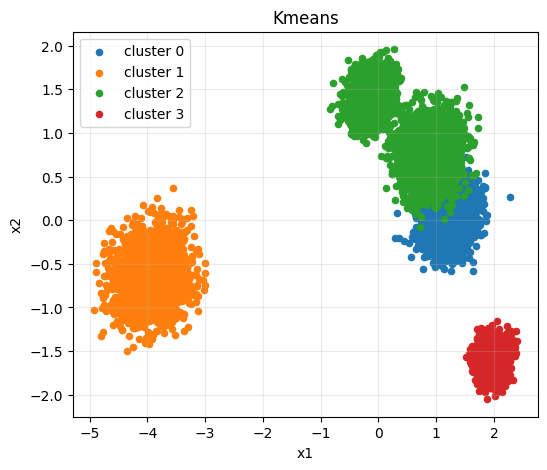

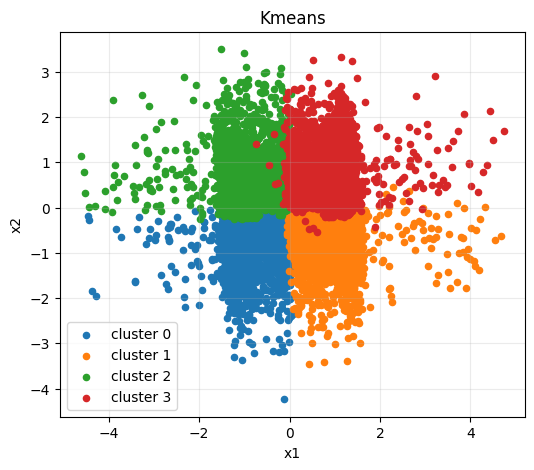

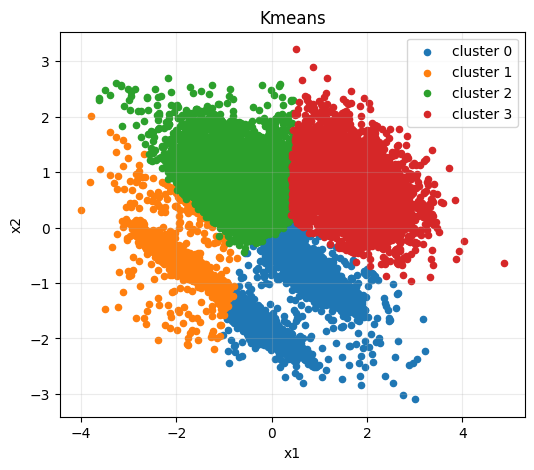

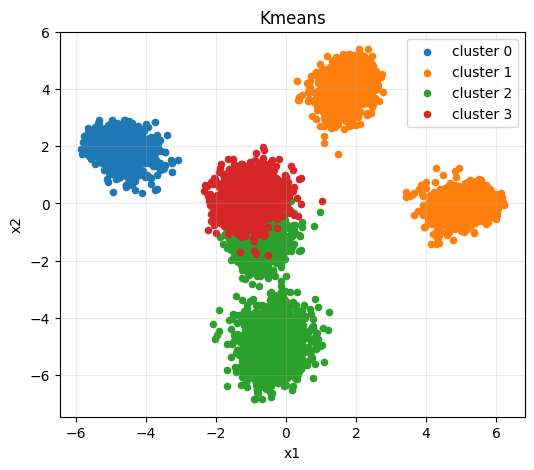

In [29]:
results = {}
k = 4
c=0
for i in x_scaled:
    model = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = model.fit_predict(i)
    #print(labels)
    #print(model.cluster_centers_)
    
    plot_clusters(i,labels,"Kmeans",save_file=image_folder+"Kmeans_"+datasets_files[c].replace(data_folder,'')+".png")
    save_with_clusters(labels,datasets[c],save_path=artifacts_folder+"labels/"+"Kmeans_"+datasets_files[c].replace(data_folder,''))
    del model
    results["Kmeans-"+datasets_files[c].replace(data_folder,'')]= [safe_internal_metrics(i, labels),summarize_labels(labels)]
    c+=1



C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


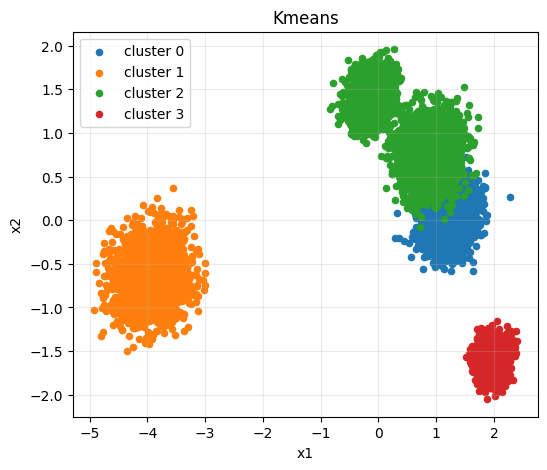

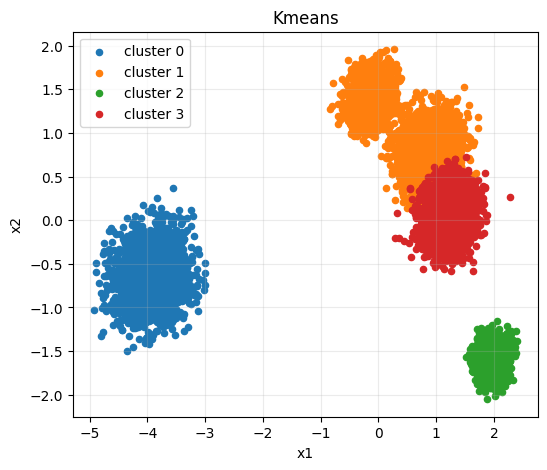

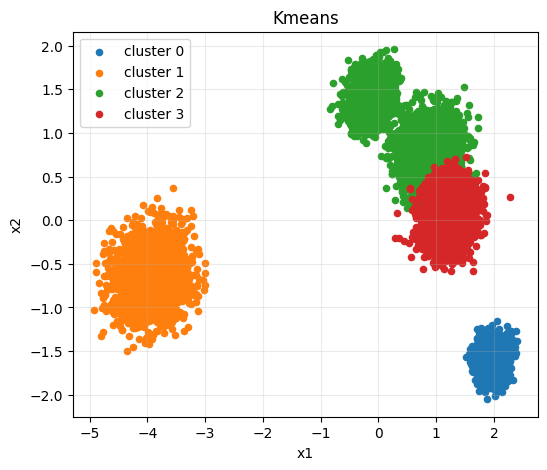

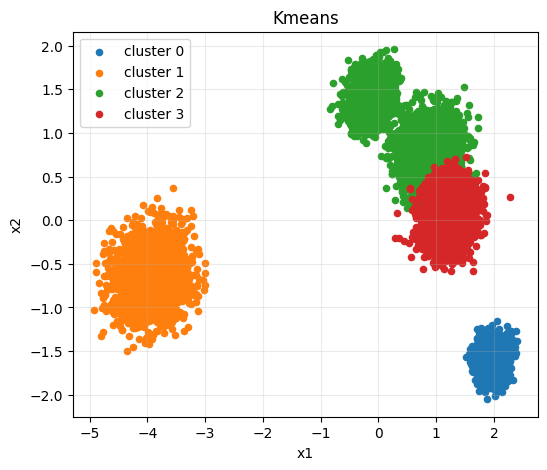

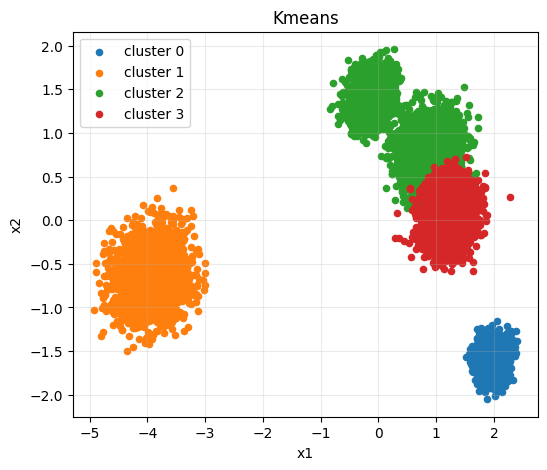

In [30]:
c=0
for i in range(1,6):
    model = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE+i)
    labels = model.fit_predict(x_scaled[0])
    #print(labels)
    #print(model.cluster_centers_)
    
    plot_clusters(x_scaled[0],labels,"Kmeans",save_file=image_folder+"Kmeans_"+datasets_files[c].replace(data_folder,'')+".png")
   
    del model

(12000,)


C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(8000,)


C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(15000,)


C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(10000,)


C:\Users\study\AppData\Local\Temp\ipykernel_26512\3043772612.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


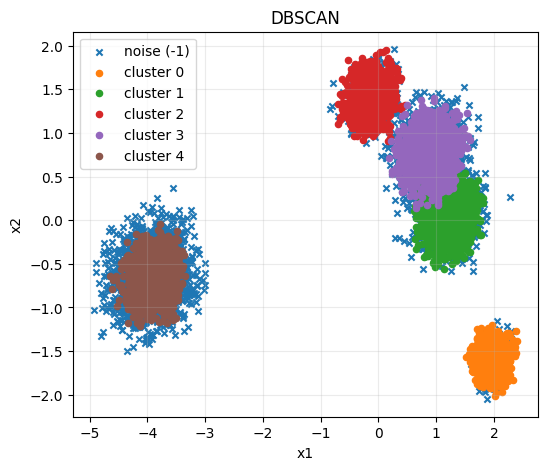

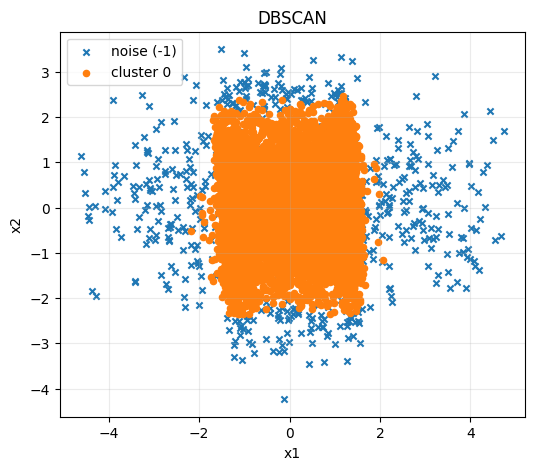

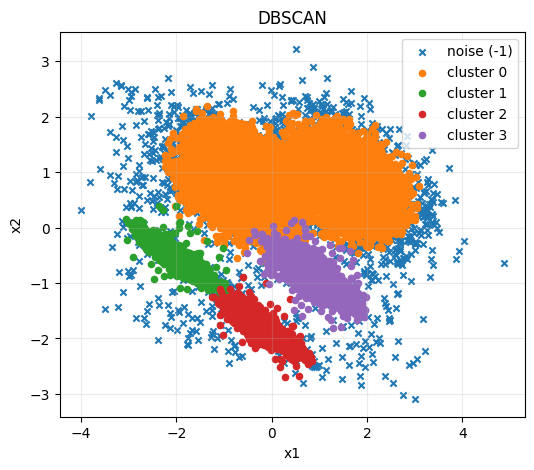

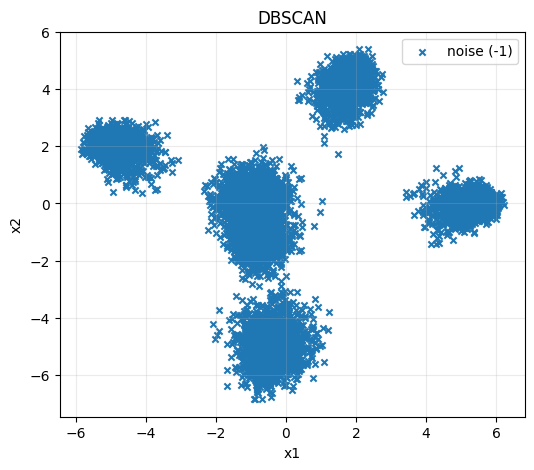

In [31]:
c=0
for i in x_scaled:

    db = DBSCAN(eps=0.5, min_samples=50)
    labels = db.fit_predict(i)
    print(labels.shape)
    plot_clusters(i,labels,"DBSCAN",save_file=image_folder+"DBSCAN_"+datasets_files[c].replace(data_folder,'')+".png")
    del db
    
    #stats = summarize_labels(labels)
  
    save_with_clusters(labels,datasets[c],save_path=artifacts_folder+"labels/"+"DBSCAN_"+datasets_files[c].replace(data_folder,''))
    results["DBSCAN-"+datasets_files[c].replace(data_folder,'')] = [safe_internal_metrics(i, labels),summarize_labels(labels)]
    c+=1


In [32]:
results

{'Kmeans-S07-hw-dataset-01.csv': [{'silhouette': 0.38330054183984447,
   'calinski_harabasz': 9427.499744196683,
   'davies_bouldin': 1.1603490405338497},
  {'n_points': 12000, 'n_clusters': 4, 'n_noise': 0.0, 'noise_share': 0.0}],
 'Kmeans-S07-hw-dataset-02.csv': [{'silhouette': 0.2514805632951281,
   'calinski_harabasz': 2915.565357085485,
   'davies_bouldin': 1.2998187751155688},
  {'n_points': 8000, 'n_clusters': 4, 'n_noise': 0.0, 'noise_share': 0.0}],
 'Kmeans-S07-hw-dataset-03.csv': [{'silhouette': 0.3146186578997614,
   'calinski_harabasz': 6492.278930703822,
   'davies_bouldin': 1.1596756007747975},
  {'n_points': 15000, 'n_clusters': 4, 'n_noise': 0.0, 'noise_share': 0.0}],
 'Kmeans-S07-hw-dataset-04.csv': [{'silhouette': 0.35130929768354796,
   'calinski_harabasz': 3305.735430539478,
   'davies_bouldin': 1.273259304784502},
  {'n_points': 10000, 'n_clusters': 4, 'n_noise': 0.0, 'noise_share': 0.0}],
 'DBSCAN-S07-hw-dataset-01.csv': [{'silhouette': 0.43184552373943935,
   'ca

In [33]:
save_json({"results": results}, Path(artifacts_folder)/"metrics_summary.json")